# 时间序列预测任务
数据集：气象数据，多种指标\
任务目标：预测未来某一时间点的气温/未来某一时间片段的气温

In [1]:
import warnings
warnings.filterwarnings('ignore')
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf
import matplotlib.pyplot as  plt
import matplotlib as mpl
%matplotlib inline
import numpy as np
import os
import pandas as pd

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

In [2]:
df = pd.read_csv("./data/climate.csv")
df.tail()

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
420546,31.12.2016 23:20:00,1000.07,-4.05,269.10,-8.13,73.10,4.52,3.30,1.22,2.06,3.30,1292.98,0.67,1.52,240.0
420547,31.12.2016 23:30:00,999.93,-3.35,269.81,-8.06,69.71,4.77,3.32,1.44,2.07,3.32,1289.44,1.14,1.92,234.3
420548,31.12.2016 23:40:00,999.82,-3.16,270.01,-8.21,67.91,4.84,3.28,1.55,2.05,3.28,1288.39,1.08,2.00,215.2
420549,31.12.2016 23:50:00,999.81,-4.23,268.94,-8.53,71.80,4.46,3.20,1.26,1.99,3.20,1293.56,1.49,2.16,225.8
420550,01.01.2017 00:00:00,999.82,-4.82,268.36,-8.42,75.70,4.27,3.23,1.04,2.01,3.23,1296.38,1.23,1.96,184.9


# 构建序列数据
dataset表示输入的数据集，里面可以是一个或者多个列特征\
history_size表示时间窗口的大小:\
indices = range(i-history_size, i)表示窗口序列索引，i表示每个窗口的起始位置，即(0, 0+history_size) (1, 1+history_size)...\
target_size表示要预测的结果是窗口后的第几个时间点，0则表示下一时间点的预测结果，取其当作标签

In [3]:
def univariate_data(dataset, start_index, end_index, history_size, target_size):
    data = []
    labels = []
    
    start_index = start_index + history_size
    if end_index is None:
        end_index = len(dataset) - target_size
    
    for i in range(start_index, end_index):
        indices = range(i - history_size, i)
        # reshape data from (history_size) to (history_size, 1)
        data.append(np.reshape(dataset[indices], (history_size, 1)))
        labels.append(dataset[i+target_size])
    
    return np.array(data), np.array(labels)

前30w个样本数据当作训练的，剩余的当作验证集

In [4]:
TRAIN_SPLIT = 300000
tf.random.set_seed(12)

# 单特征训练模型

In [5]:
# 只选一个温度
uni_data = df['T (degC)']
uni_data.index = df['Date Time']
uni_data.head()

Date Time
01.01.2009 00:10:00   -8.02
01.01.2009 00:20:00   -8.41
01.01.2009 00:30:00   -8.51
01.01.2009 00:40:00   -8.31
01.01.2009 00:50:00   -8.27
Name: T (degC), dtype: float64

array([<Axes: xlabel='Date Time'>], dtype=object)

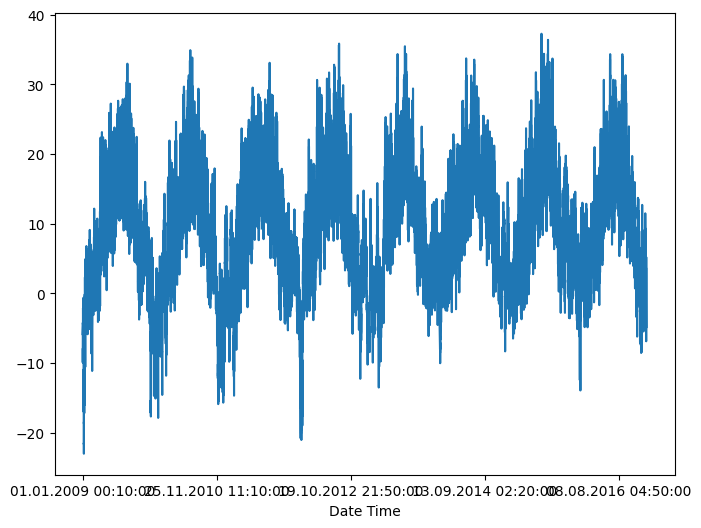

In [6]:
# 展示当前特征
uni_data.plot(subplots=True)

In [7]:
uni_data = uni_data.values

# 数据预处理：标准化操作

In [8]:
uni_train_mean = uni_data[:TRAIN_SPLIT].mean()
uni_train_std = uni_data[:TRAIN_SPLIT].std()

In [9]:
uni_data = (uni_data-uni_train_mean) / uni_train_std

窗口大小为20条数据，预测一个时刻的气温

In [10]:
univariate_past_history = 20
univariate_future_target = 0

x_train_uni, y_train_uni = univariate_data(uni_data, 0, TRAIN_SPLIT, 
                                           univariate_past_history,
                                           univariate_future_target
                                          )

x_var_uni, y_var_uni = univariate_data(uni_data, TRAIN_SPLIT, None,
                                       univariate_past_history,
                                       univariate_future_target
                                      )

数据与标签维度

In [11]:
x_train_uni.shape

(299980, 20, 1)

In [12]:
x_var_uni.shape

(120531, 20, 1)

训练特征X与标签Y

In [13]:
print('Single window of past history')
print(x_train_uni[0])
print("\n Traget temperature to predict")
print(y_train_uni[0])

Single window of past history
[[-1.99766294]
 [-2.04281897]
 [-2.05439744]
 [-2.0312405 ]
 [-2.02660912]
 [-2.00113649]
 [-1.95134907]
 [-1.95134907]
 [-1.98492663]
 [-2.04513467]
 [-2.08334362]
 [-2.09723778]
 [-2.09376424]
 [-2.09144854]
 [-2.07176515]
 [-2.07176515]
 [-2.07639653]
 [-2.08913285]
 [-2.09260639]
 [-2.10418486]]

 Traget temperature to predict
-2.1041848598100876


# 时间序列样本展示

In [14]:
def create_time_steps(length):
    time_steps = []
    for i in range(-length, 0, 1):
        time_steps.append(i)
    return time_steps

In [15]:
def show_plot(plot_data, delta, title):
    labels = ['History', 'True Future', 'Model Prediction']
    marker = ['.-', 'rx', 'go']
    time_steps = create_time_steps(plot_data[0].shape[0])
    if delta:
        future = delta
    else:
        future = 0
    
    plt.title(title)
    for i, x in enumerate(plot_data):
        if i:
            plt.plot(future, plot_data[i], marker[i], markersize=10, label=labels[i])
        else:
            plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
    plt.legend()
    plt.xlim([time_steps[0], (future+5)*2])
    plt.xlabel('Time-Step')
    return plt

In [16]:
[x_train_uni[0], y_train_uni[0]][0].shape[0]

20

<module 'matplotlib.pyplot' from 'C:\\anaconda\\envs\\tf2\\lib\\site-packages\\matplotlib\\pyplot.py'>

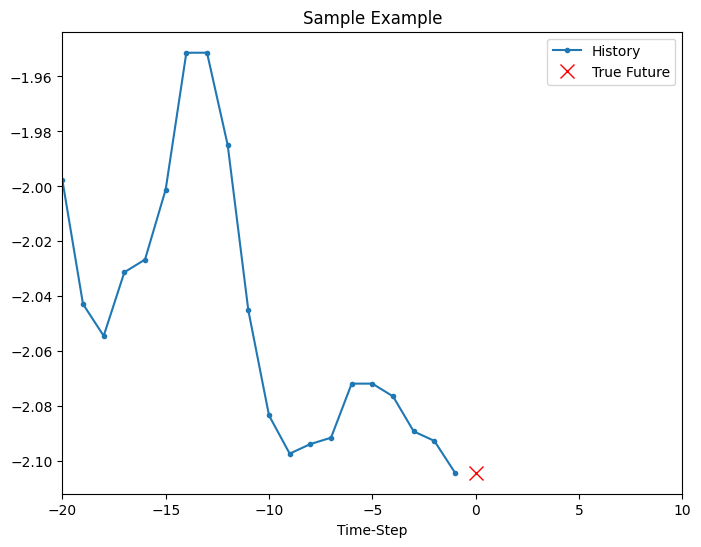

In [17]:
show_plot([x_train_uni[0], y_train_uni[0]], 0, 'Sample Example')

In [18]:
# 构建RNN模型进行预测
BATCH_SIZE = 256
BUFFER_SIZE = 10000

train_univariate = tf.data.Dataset.from_tensor_slices((x_train_uni, y_train_uni))
train_univariate = train_univariate.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_uniariate = tf.data.Dataset.from_tensor_slices((x_var_uni, y_var_uni))
val_uniariate = val_uniariate.batch(BATCH_SIZE).repeat()

In [19]:
train_univariate

<RepeatDataset element_spec=(TensorSpec(shape=(None, 20, 1), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>

In [20]:
x_train_uni.shape[-2:]

(20, 1)

# LSTM模型

In [21]:
simple_lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(8, input_shape=x_train_uni.shape[-2:]),
    tf.keras.layers.Dense(1)
])

simple_lstm_model.compile(optimizer='adam', loss='mae')

得到一个batch的测试结果

In [22]:
for x, y in val_uniariate.take(1):
    print(simple_lstm_model.predict(x).shape)

8/8 [==============================] - 0s 2ms/step
(256, 1)


In [23]:
EVALUATION_INTERVAL = 600
EPOCHS = 10

simple_lstm_model.fit(train_univariate, epochs=EPOCHS,
                      steps_per_epoch=EVALUATION_INTERVAL,
                      validation_data=val_uniariate, validation_steps=50)

Epoch 1/10
600/600 [==============================] - 5s 6ms/step - loss: 0.1925 - val_loss: 0.0294
Epoch 2/10
600/600 [==============================] - 3s 5ms/step - loss: 0.0331 - val_loss: 0.0213
Epoch 3/10
600/600 [==============================] - 3s 5ms/step - loss: 0.0254 - val_loss: 0.0180
Epoch 4/10
600/600 [==============================] - 3s 5ms/step - loss: 0.0211 - val_loss: 0.0157
Epoch 5/10
600/600 [==============================] - 3s 5ms/step - loss: 0.0194 - val_loss: 0.0144
Epoch 6/10
600/600 [==============================] - 3s 6ms/step - loss: 0.0178 - val_loss: 0.0139
Epoch 7/10
600/600 [==============================] - 3s 6ms/step - loss: 0.0170 - val_loss: 0.0138
Epoch 8/10
600/600 [==============================] - 3s 6ms/step - loss: 0.0164 - val_loss: 0.0124
Epoch 9/10
600/600 [==============================] - 3s 6ms/step - loss: 0.0158 - val_loss: 0.0126
Epoch 10/10
600/600 [==============================] - 3s 6ms/step - loss: 0.0155 - val_loss: 0.0121

# 用训练好的模型预测结果
展示其中部分数据的预测结果

8/8 [==============================] - 0s 2ms/step


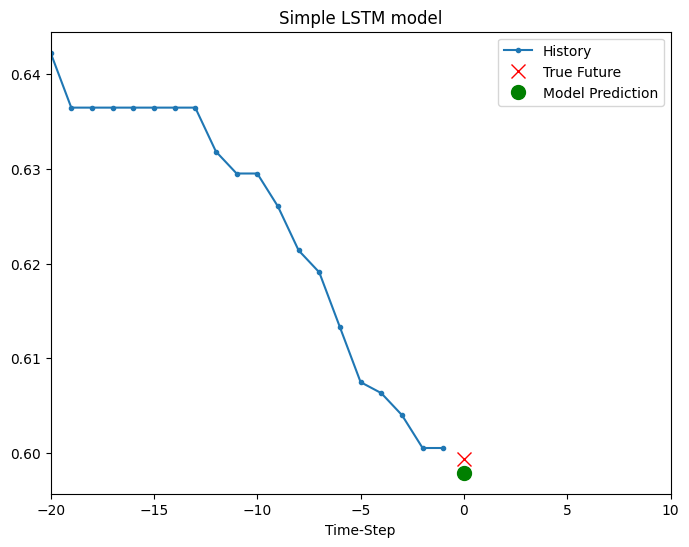

8/8 [==============================] - 0s 2ms/step


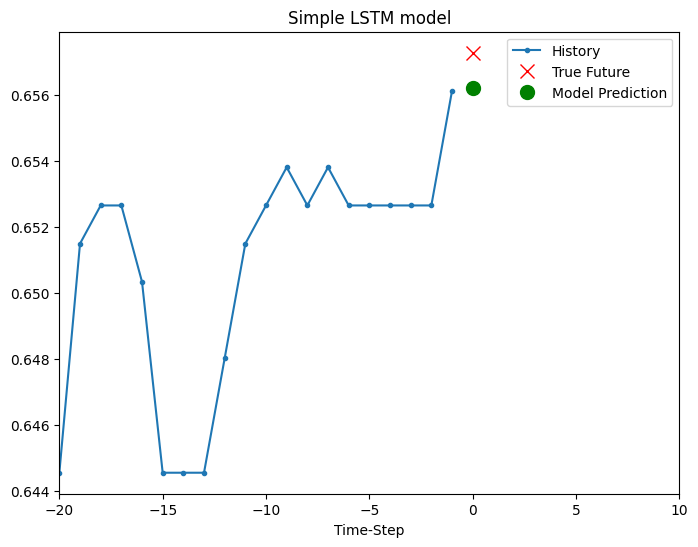

8/8 [==============================] - 0s 2ms/step


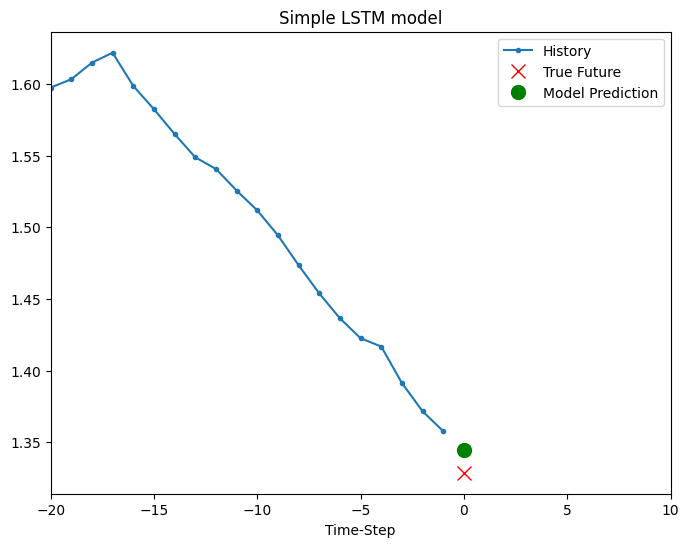

In [24]:
for x, y in val_uniariate.take(3):
    plot = show_plot([x[0].numpy(), y[0].numpy(),
                     simple_lstm_model.predict(x)[0]], 0, 'Simple LSTM model')
    plot.show()

# 多用些特征看看效果

In [25]:
feature_considered = ['p (mbar)', 'T (degC)', 'rho (g/m**3)']

In [26]:
features = df[feature_considered]
features.index = df['Date Time']
features.head()

,p (mbar),T (degC),rho (g/m**3)
Date Time,,,
01.01.2009 00:10:00,996.52,-8.02,1307.75
01.01.2009 00:20:00,996.57,-8.41,1309.80
01.01.2009 00:30:00,996.53,-8.51,1310.24
01.01.2009 00:40:00,996.51,-8.31,1309.19
01.01.2009 00:50:00,996.51,-8.27,1309.00


array([<Axes: xlabel='Date Time'>, <Axes: xlabel='Date Time'>,
       <Axes: xlabel='Date Time'>], dtype=object)

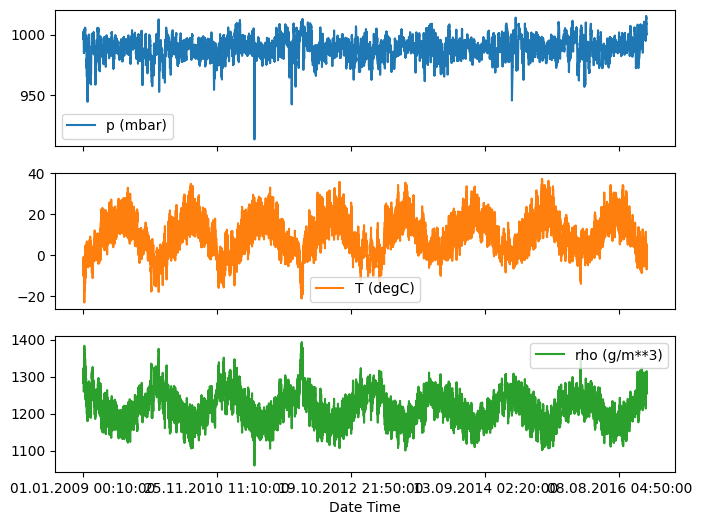

In [27]:
features.plot(subplots=True)

In [28]:
dataset = features.values
data_mean = dataset[:TRAIN_SPLIT].mean(axis=0)
data_std = dataset[:TRAIN_SPLIT].std(axis=0)

In [29]:
dataset = (dataset - data_mean) / data_std

# 时间窗口数据制作
只预测接下来一个时间点的结果

In [30]:
def multivariate_data(dataset, target, start_index, end_index, history_size,
                      target_size, step, single_step=False):
    data = []
    labels = []
    
    start_index = start_index + history_size
    if end_index is None:
        # 测试集用的
        end_index = len(dataset) - target_size
    
    for i in range(start_index, end_index):
        indices = range(i-history_size, i, step)  # 索引为range(0, 720, 6), range(0, 720, 6) range(1, 721, 6)
        data.append(dataset[indices])
        
        if single_step:
            labels.append(target[i+target_size])    # （720+72） （721+72）
        else:
            labels.append(target[i:i+target_size])
    
    return np.array(data), np.array(labels)

选择训练窗口为5天的数据，5 * 24 * 6=720条记录\
step=6表示每隔6个时间点实际取一次数据，即窗口大小：720/6=120, 索引为range(0, 720, 6), range(0, 720, 6)\
要预测的结果(标签)为12小时后的温度值，即12*6=72, 72个时间点后的结果

In [31]:
past_history = 720
future_target = 72
STEP = 6

x_train_single, y_train_single = multivariate_data(dataset, dataset[:, 1], 0, 
                                                   TRAIN_SPLIT, past_history,
                                                   future_target, STEP,
                                                   single_step=True
                                                  )
x_val_single, y_val_single = multivariate_data(dataset, dataset[:, 1],
                                               TRAIN_SPLIT, None, past_history,
                                               future_target, STEP,
                                               single_step=True
                                              )

数据维度

In [32]:
x_train_single.shape, y_train_single.shape

((299280, 120, 3), (299280,))

In [33]:
x_val_single.shape, y_val_single.shape

((119759, 120, 3), (119759,))

# 构建训练数据

In [34]:
train_data_single = tf.data.Dataset.from_tensor_slices((x_train_single, y_train_single))
train_data_single = train_data_single.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_single = tf.data.Dataset.from_tensor_slices((x_val_single, y_val_single))
val_data_single = val_data_single.batch(BATCH_SIZE).repeat()

In [35]:
train_data_single

<RepeatDataset element_spec=(TensorSpec(shape=(None, 120, 3), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>

In [36]:
single_step_model = tf.keras.models.Sequential()
single_step_model.add(tf.keras.layers.LSTM(32,
                                           input_shape=x_train_single.shape[-2:]))
single_step_model.add(tf.keras.layers.Dense(1))

single_step_model.compile(optimizer=tf.keras.optimizers.RMSprop(), loss='mae')

In [37]:
for x, y in val_data_single.take(1):
    print(single_step_model.predict(x).shape)

8/8 [==============================] - 0s 8ms/step
(256, 1)


In [48]:
single_step_history = single_step_model.fit(train_data_single, epochs=EPOCHS,
                                            steps_per_epoch=EVALUATION_INTERVAL,
                                            validation_data=val_data_single,
                                            validation_steps=50)

Epoch 1/10
600/600 [==============================] - 48s 80ms/step - loss: 0.1857 - val_loss: 0.2679
Epoch 2/10
600/600 [==============================] - 52s 87ms/step - loss: 0.1827 - val_loss: 0.2502
Epoch 3/10
600/600 [==============================] - 52s 88ms/step - loss: 0.1859 - val_loss: 0.2700
Epoch 4/10
600/600 [==============================] - 51s 86ms/step - loss: 0.1802 - val_loss: 0.2628
Epoch 5/10
600/600 [==============================] - 52s 86ms/step - loss: 0.1863 - val_loss: 0.2718
Epoch 6/10
600/600 [==============================] - 51s 85ms/step - loss: 0.1768 - val_loss: 0.2693
Epoch 7/10
600/600 [==============================] - 51s 85ms/step - loss: 0.1860 - val_loss: 0.2633
Epoch 8/10
600/600 [==============================] - 51s 85ms/step - loss: 0.1741 - val_loss: 0.2681
Epoch 9/10
600/600 [==============================] - 50s 84ms/step - loss: 0.1855 - val_loss: 0.2731
Epoch 10/10
600/600 [==============================] - 50s 84ms/step - loss: 0.174

# 训练结果展示

In [76]:
def plot_train_history(history, title):
    loss = history.history['loss'][1:]
    val_loss = history.history['val_loss'][1:]
    
    epochs = range(len(loss))
    
    plt.figure()
    
    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title(title)
    plt.legend()
    
    plt.show()

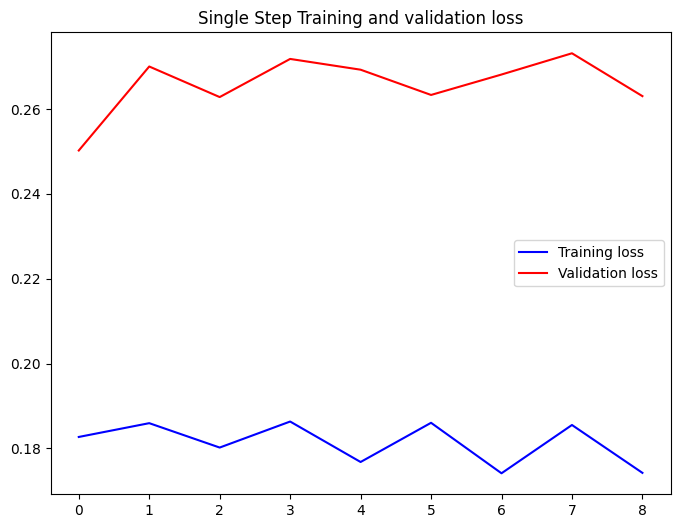

In [77]:
plot_train_history(single_step_history, 'Single Step Training and validation loss')

8/8 [==============================] - 0s 10ms/step


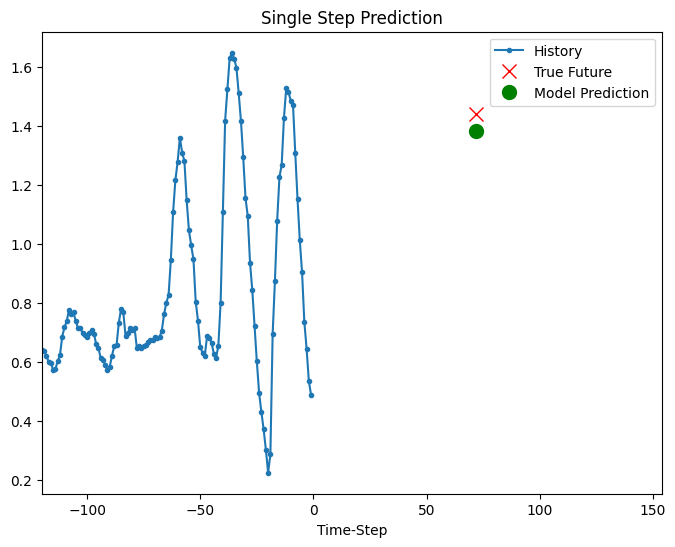

8/8 [==============================] - 0s 9ms/step


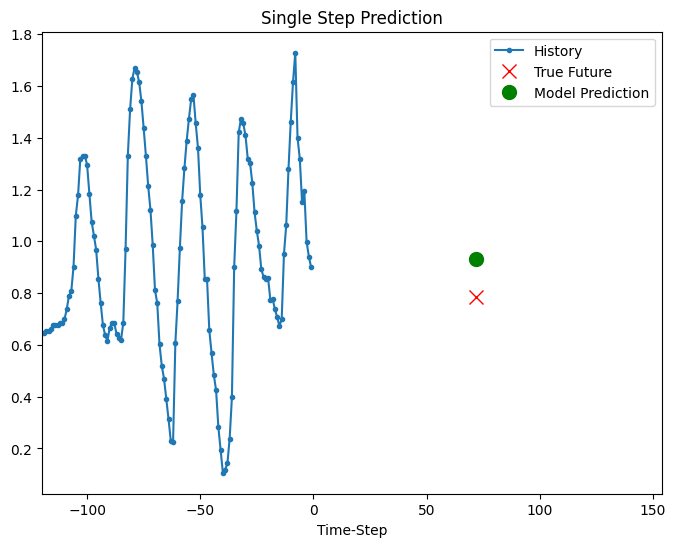

8/8 [==============================] - 0s 9ms/step


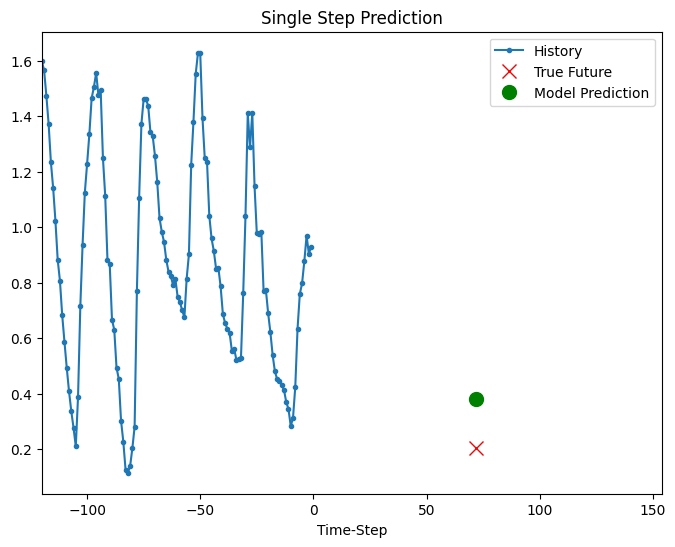

In [50]:
for x, y in val_data_single.take(3):
    plot = show_plot([x[0][:, 1].numpy(), y[0].numpy(),
                      single_step_model.predict(x)[0]], 72,
                      'Single Step Prediction')
    plt.show()

In [51]:
# 预测接下来一个时间片段的结果
future_target = 72
x_train_multi, y_train_multi = multivariate_data(dataset, dataset[:, 1], 0,
                                                 TRAIN_SPLIT, past_history,
                                                 future_target, STEP)
x_val_multi, y_val_multi = multivariate_data(dataset, dataset[:, 1],
                                             TRAIN_SPLIT, None, past_history,
                                             future_target, STEP)

In [52]:
x_train_multi.shape, y_train_multi.shape

((299280, 120, 3), (299280, 72))

In [53]:
train_data_multi = tf.data.Dataset.from_tensor_slices((x_train_multi, y_train_multi))
train_data_multi = train_data_multi.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_multi = tf.data.Dataset.from_tensor_slices((x_val_multi, y_val_multi))
val_data_multi = val_data_multi.batch(BATCH_SIZE).repeat()

In [54]:
# 要预测的序列
def multi_step_plot(history, true_future, prediction):
    plt.figure(figsize=(12, 6))
    num_in = create_time_steps(len(history))
    num_out = len(true_future)
    
    plt.plot(num_in, np.array(history[:, 1]), label='History')
    plt.plot(np.arange(num_out)/STEP, np.array(true_future), 'bo', label='True Future')
    if prediction.any():
        plt.plot(np.arange(num_out)/STEP, np.array(prediction), 'ro', label='Predicted Future')
    plt.legend(loc='upper left')
    plt.show()

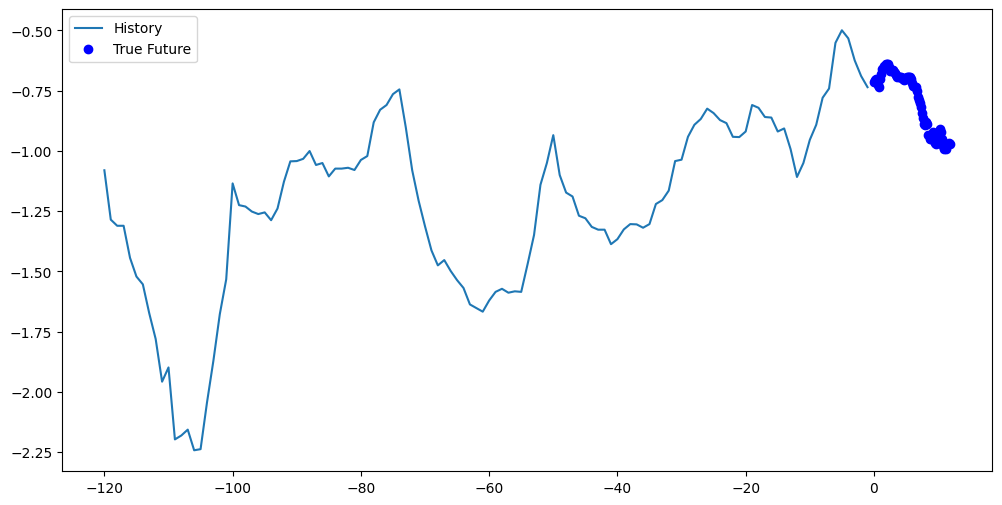

In [55]:
for x, y in train_data_multi.take(1):
    multi_step_plot(x[0], y[0], np.array([0]))

2层的LSTM网络，预测72个时间的结果

In [69]:
multi_step_model = tf.keras.models.Sequential()
multi_step_model.add(tf.keras.layers.LSTM(32,
                                          return_sequences=True,
                                          input_shape=x_train_multi.shape[-2:]))
multi_step_model.add(tf.keras.layers.LSTM(16, activation='relu'))
multi_step_model.add(tf.keras.layers.Dense(72))

multi_step_model.compile(optimizer=tf.keras.optimizers.RMSprop(clipvalue=1.0), loss='mae')

每个序列输入后都会得到72个预测结果

In [70]:
for x, y in val_data_multi.take(1):
    print(multi_step_model.predict(x).shape)

8/8 [==============================] - 0s 13ms/step
(256, 72)


In [79]:
multi_step_history = multi_step_model.fit(train_data_multi, epochs=EPOCHS+5,
                                          steps_per_epoch=EVALUATION_INTERVAL,
                                          validation_data=val_data_multi,
                                          validation_steps=50)

Epoch 1/15
600/600 [==============================] - 114s 191ms/step - loss: 0.1709 - val_loss: 0.1788
Epoch 2/15
600/600 [==============================] - 118s 197ms/step - loss: 0.1661 - val_loss: 0.1985
Epoch 3/15
600/600 [==============================] - 119s 198ms/step - loss: 0.1693 - val_loss: 0.1876
Epoch 4/15
600/600 [==============================] - 115s 191ms/step - loss: 0.1638 - val_loss: 0.1955
Epoch 5/15
600/600 [==============================] - 119s 199ms/step - loss: 0.1671 - val_loss: 0.1875
Epoch 6/15
600/600 [==============================] - 118s 197ms/step - loss: 0.1613 - val_loss: 0.1997
Epoch 7/15
600/600 [==============================] - 118s 197ms/step - loss: 0.1650 - val_loss: 0.1924
Epoch 8/15
600/600 [==============================] - 120s 199ms/step - loss: 0.1583 - val_loss: 0.1807
Epoch 9/15
600/600 [==============================] - 123s 204ms/step - loss: 0.1636 - val_loss: 0.1847
Epoch 10/15
600/600 [==============================] - 121s 201m

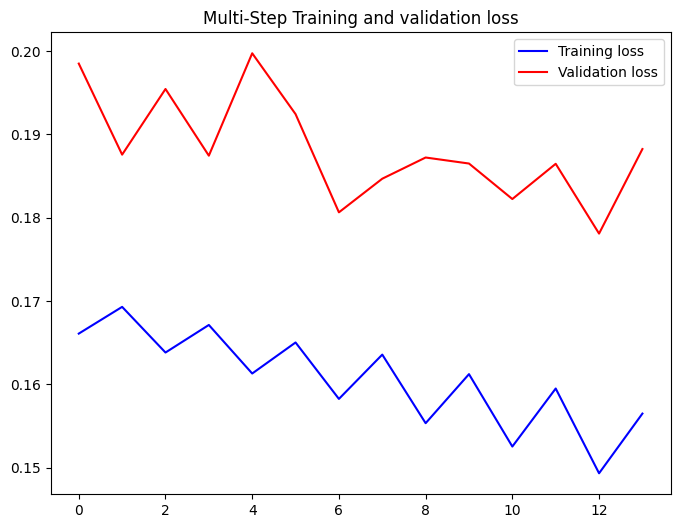

In [80]:
plot_train_history(multi_step_history, 'Multi-Step Training and validation loss')

8/8 [==============================] - 0s 20ms/step


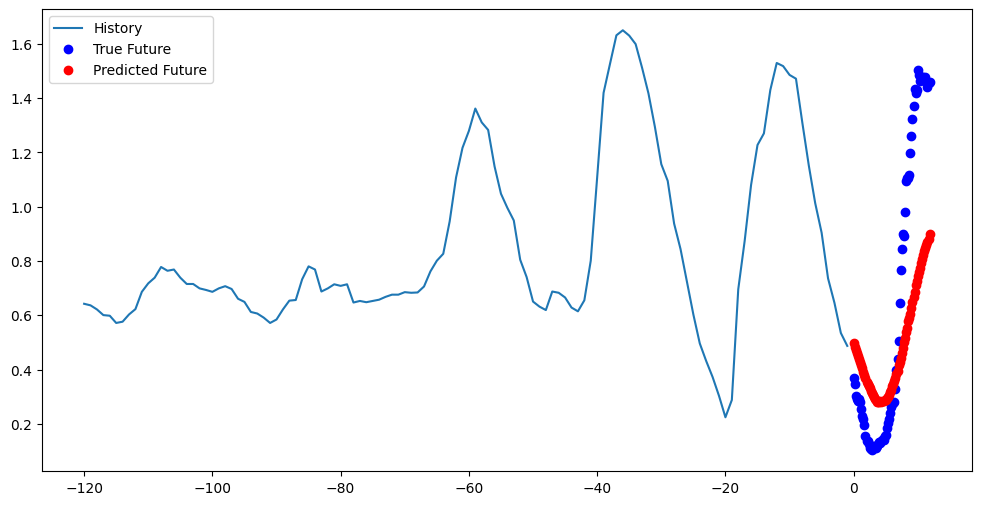

8/8 [==============================] - 0s 18ms/step


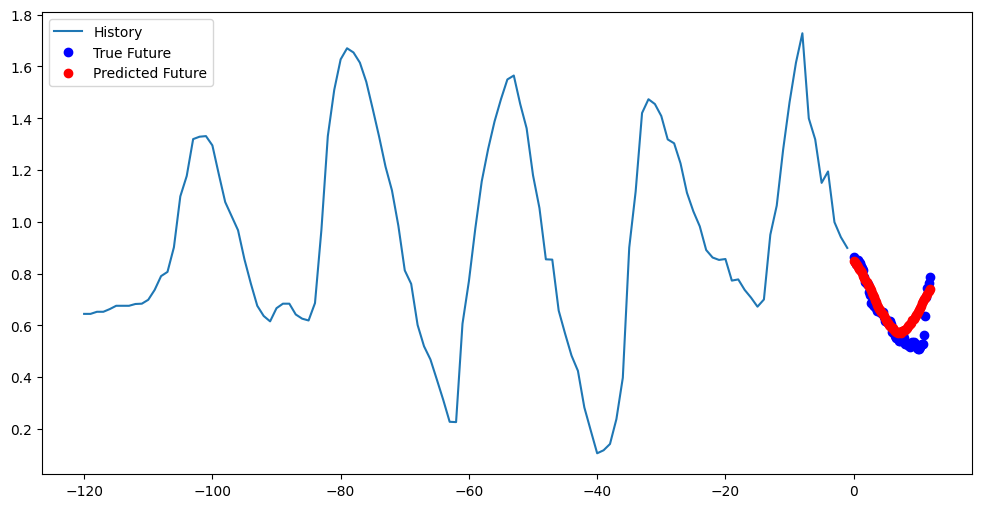

8/8 [==============================] - 0s 17ms/step


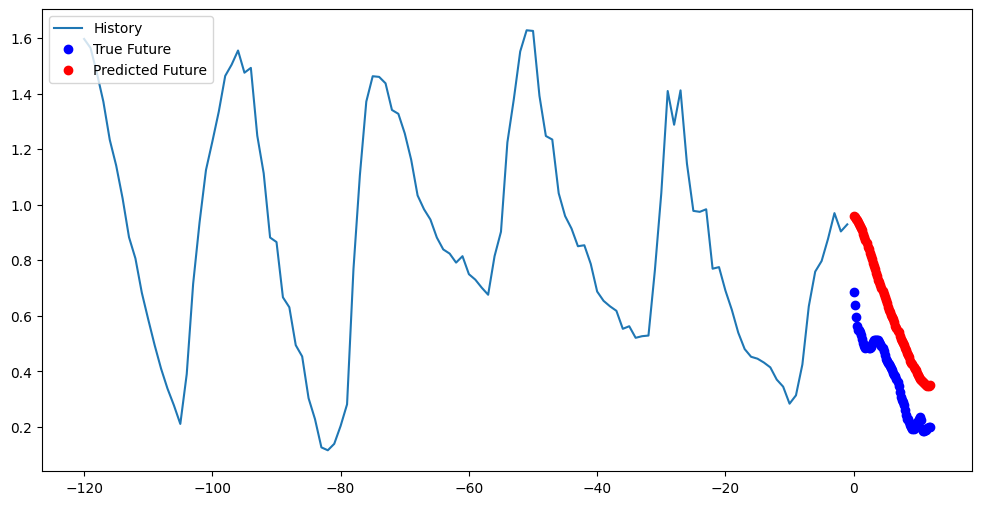

In [81]:
for x, y in val_data_multi.take(3):
    multi_step_plot(x[0], y[0], multi_step_model.predict(x)[0])

# 尝试新的模型构建方法

In [89]:
input_shape = x_train_multi.shape[-2:]
inputs = tf.keras.Input(shape=input_shape)
x = tf.keras.layers.LSTM(units=16, dropout=0.5, return_sequences=True, kernel_regularizer=tf.keras.regularizers.l2(0.01))(inputs)
x = tf.keras.layers.LeakyReLU()(x)
x = tf.keras.layers.LSTM(units=32, dropout=0.5, return_sequences=True, kernel_regularizer=tf.keras.regularizers.l2(0.01))(inputs)
x = tf.keras.layers.LeakyReLU()(x)
x = tf.keras.layers.LSTM(units=64, dropout=0.5, kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
x = tf.keras.layers.LeakyReLU()(x)
x = tf.keras.layers.Dense(128, kernel_initializer='random_normal', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
x = tf.keras.layers.Dropout(0.5)(x)
outputs = tf.keras.layers.Dense(72)(x)
model = tf.keras.Model(inputs, outputs)
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 120, 3)]          0         
                                                                 
 lstm_20 (LSTM)              (None, 120, 32)           4608      
                                                                 
 leaky_re_lu_10 (LeakyReLU)  (None, 120, 32)           0         
                                                                 
 lstm_21 (LSTM)              (None, 64)                24832     
                                                                 
 leaky_re_lu_11 (LeakyReLU)  (None, 64)                0         
                                                                 
 dense_8 (Dense)             (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0   

In [91]:
model.compile(optimizer=tf.keras.optimizers.RMSprop(clipvalue=1.0), loss='mae')

In [92]:
model_history = model.fit(train_data_multi, epochs=EPOCHS,
                          steps_per_epoch=EVALUATION_INTERVAL,
                          validation_data=val_data_multi,
                          validation_steps=50)

Epoch 1/10
600/600 [==============================] - 248s 409ms/step - loss: 0.4578 - val_loss: 0.2636
Epoch 2/10
600/600 [==============================] - 286s 477ms/step - loss: 0.3291 - val_loss: 0.3002
Epoch 3/10
600/600 [==============================] - 291s 485ms/step - loss: 0.3262 - val_loss: 0.2538
Epoch 4/10
600/600 [==============================] - 288s 480ms/step - loss: 0.3116 - val_loss: 0.2815
Epoch 5/10
600/600 [==============================] - 296s 493ms/step - loss: 0.3146 - val_loss: 0.2839
Epoch 6/10
600/600 [==============================] - 290s 483ms/step - loss: 0.3017 - val_loss: 0.2485
Epoch 7/10
600/600 [==============================] - 294s 490ms/step - loss: 0.3083 - val_loss: 0.2519
Epoch 8/10
600/600 [==============================] - 295s 492ms/step - loss: 0.2949 - val_loss: 0.2457
Epoch 9/10
600/600 [==============================] - 299s 498ms/step - loss: 0.3050 - val_loss: 0.2591
Epoch 10/10
600/600 [==============================] - 297s 496m

8/8 [==============================] - 1s 22ms/step


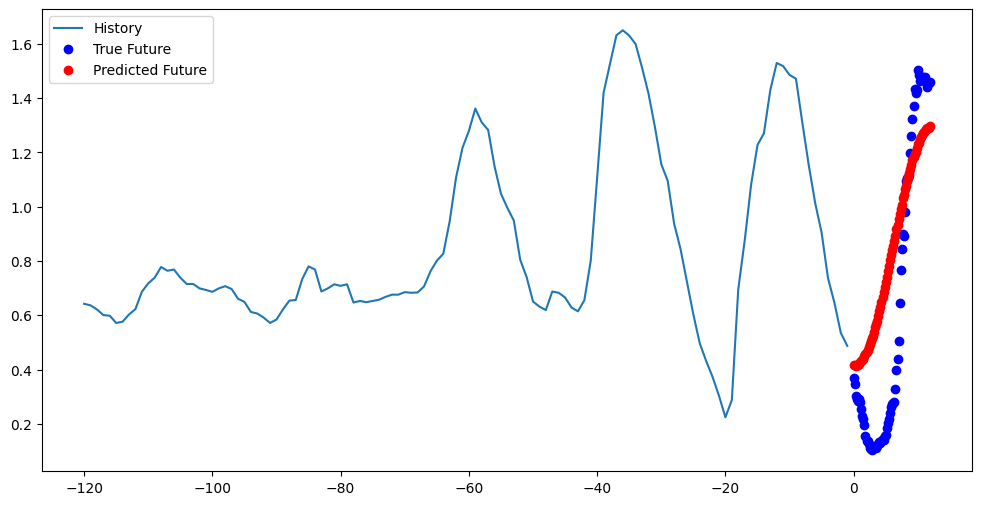

8/8 [==============================] - 0s 22ms/step


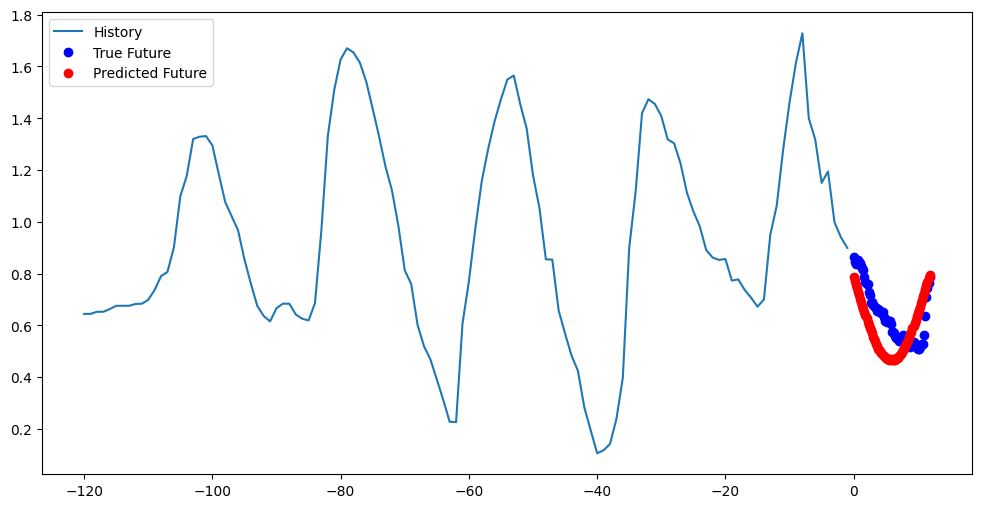

8/8 [==============================] - 0s 23ms/step


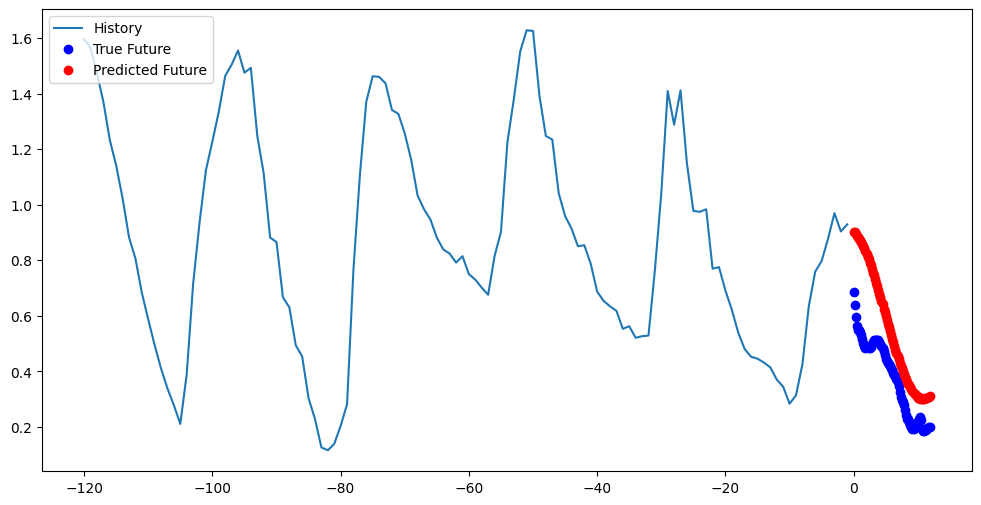

In [93]:
for x, y in val_data_multi.take(3):
    multi_step_plot(x[0], y[0], model.predict(x)[0])